# Import packages

In [48]:
# %load_ext autoreload
# %autoreload 2

import file_handler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
import arabic_reshaper
import re

import matplotlib.cm as cmtest_roads
import matplotlib as mpl

import osmnx as ox
import importlib


from sklearn.linear_model import LinearRegression


## basic Loading and table drawing functions

In [108]:
def getRoadChart_by_time(start_year,end_year,road_name,city):
    roads = []
    for year in range(start_year, end_year+1):
        for month in range(1, 13):
            item = ''
            try:
                item = file_handler.getRoadAddress(
                    str(year), str(month), city, road_name)
                if item != None:
                    roads.append(item)
            except Exception as e:
                print(f"Error: {e}")
                break

    df = file_handler.load_csv_file(roads[0])
    for i in range(len(roads)):
        df = df._append(file_handler.load_csv_file(roads[i]))
    df = df.reset_index()
    return df


def getRoadChart(road):
    city = 'تهران'

    roads = []

    for year in range(1395, 1403):
        for month in range(1, 13):
            item = ''
            try:
                item = file_handler.getRoadAddress(
                    str(year), str(month), city, road)
                # print(item)
                if item != None:
                    roads.append(item)
            except:
                break

    df = file_handler.load_csv_file(roads[0])
    for i in range(len(roads)):
        df = df._append(file_handler.load_csv_file(roads[i]))
    df = df.reset_index()
    return df

def Draw_road_time_series(df2):
    plt.figure()  # Create a new figure for each plot
    df2['زمان شروع'] = df2['زمان شروع'].apply(lambda x: x.split()[0]) # drop the 00:00:00 part
    plt.plot(df2['زمان شروع'], df2['تعداد کل وسیله نقلیه'])
    x=df2['زمان شروع']
    # Customize x-axis ticks and labels
    # Rotate x-axis labels for better readability
    plt.xticks(x[::365],  rotation=45)
    # Add more customization as needed
    plt.title(file_handler.persian_fix(df2['نام محور'][0]))
    # Add title, labels, legend, etc.
    plt.xlabel(file_handler.persian_fix('تاریخ'))
    plt.ylabel(file_handler.persian_fix('تعداد خودرو '))
    plt.legend(['Legend'])

def Draw_road_time_series_smooth(df2, window=7):
    plt.figure()  # Create a new figure for each plot
    df2['زمان شروع'] = df2['زمان شروع'].apply(lambda x: x.split()[0]) # drop the 00:00:00 part
    ave = df2['تعداد کل وسیله نقلیه'].rolling(window=window).mean()
    plt.plot(df2['زمان شروع'], ave)
    x=df2['زمان شروع']
    # Customize x-axis ticks and labels
    # Rotate x-axis labels for better readability
    plt.xticks(x[::365],  rotation=45)
    # Add more customization as needed
    plt.title(file_handler.persian_fix(df2['نام محور'][0]+ " Smooth") )
    # Add title, labels, legend, etc.
    plt.xlabel(file_handler.persian_fix('تاریخ'))
    plt.ylabel(file_handler.persian_fix('تعداد خودرو '))
    plt.legend(['Legend'])
    plt.savefig("img/"+df2['نام محور'][0]+".png",dpi=300,bbox_inches='tight')

def Draw_road_corr_matrix(road_number,sorted_models):
    aa = pd.DataFrame()
    i= 0
    for i in range(road_number):
        road_min = sorted_models[i]
        df1 = roads[road_min[0]]
        road_name = names[road_min[0]]
        df2 = df1.rename(columns={'تعداد کل وسیله نقلیه': road_name})
        aa = pd.concat([aa, df2[road_name]], axis=1)
    # plotting correlation heatmap 
    dataplot=sb.heatmap(aa.corr()) 
    
    # Setting Persian text for title
    plt.title(get_display(arabic_reshaper.reshape('ماتریس همبستگی')))
    
    # Setting Persian text for tick labels on x-axis
    plt.xticks(ticks=plt.xticks()[0], labels=[get_display(arabic_reshaper.reshape(label.get_text())) for label in plt.gca().get_xticklabels()])
    
    # Setting Persian text for tick labels on y-axis
    plt.yticks(ticks=plt.yticks()[0], labels=[get_display(arabic_reshaper.reshape(label.get_text())) for label in plt.gca().get_yticklabels()])
    
    # displaying heatmap 
    mp.show()
    # plt.show()
    # plt.savefig("img/test_corr.png")
    

## test the function on some data:

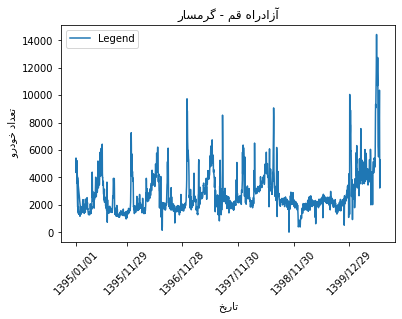

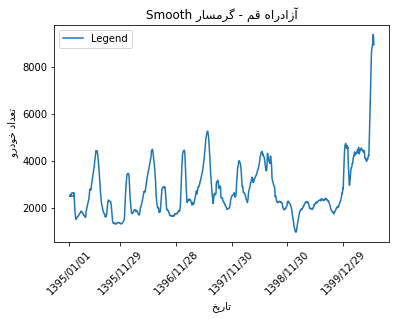

In [50]:

df2 = getRoadChart('113201')
df3 = getRoadChart('113201')

Draw_road_time_series(df2)
Draw_road_time_series_smooth(df3, window=30)

import datetime
import plotly.express as px

# import jdatetime as jd

# fa_date = jd.date(1397, 4, 23, locale=jdatetime.FA_LOCALE)
# fa_datetime = jd.datetime(1397, 4, 23, 11, 40, 30, locale=jdatetime.FA_LOCALE)
# fig = px.line(df2, x="زمان شروع", y="تعداد کل وسیله نقلیه") 
# fig.update_xaxes(calendar='jalali')
# fig.show()

# Load the road_code of each city :
load the road_code and road_name of each city and copple them

In [51]:
def Load_road_code_of_city(city):
    codes = list(map ( lambda x: re.search('([0-9]{6,6})', x).group(),file_handler.get_dayly_data_path_with_year_month_city('1395','2',str(city))))
    return codes

def Load_road_name_of_city(city):
    t = file_handler.get_dayly_data_path_with_year_month_city('1395','2',str(city))
    names = {}
    for i in range(len(t)):
        names[codes[i]] = ' '.join(t[i].split('/')[-1].split(' ')[2:-1])
    return names

def Load_roads_code_of_contry():
    codes = []
    for item in file_handler.Citys:
        codes.extend(Load_road_code_of_city(item))
    return codes

def Load_roads_name_of_contry():
    t = []
    for item in file_handler.Citys:
        t.extend(file_handler.get_dayly_data_path_with_year_month_city('1395','2',str(item)))

    names = {}
    for i in range(len(t)):
        names[codes[i]] = ' '.join(t[i].split('/')[-1].split(' ')[2:-1])
    return names

codes = Load_road_code_of_city('تهران')
names =Load_road_name_of_city('تهران')
codes
# codes = Load_roads_code_of_contry()
# names = Load_roads_name_of_contry()
# len(all_roads_name)

['113251',
 '113469',
 '113211',
 '113254',
 '113551',
 '113206',
 '113408',
 '113404',
 '113954',
 '114206',
 '113501',
 '113417',
 '113401',
 '113262',
 '113853',
 '113851',
 '114302',
 '113403',
 '113213',
 '113451',
 '113804',
 '113803',
 '113263',
 '114256',
 '113468',
 '114552',
 '113552',
 '113203',
 '113424',
 '113418',
 '113904',
 '113302',
 '113802',
 '114501',
 '114102',
 '113228',
 '113207',
 '113454',
 '113466',
 '114451',
 '113257',
 '114301',
 '113259',
 '113205',
 '113854',
 '113209',
 '113801',
 '113464',
 '113474',
 '113903',
 '113204',
 '113352',
 '113463',
 '114401',
 '113416',
 '113256',
 '113253',
 '113201',
 '113278',
 '114352',
 '113458',
 '113260',
 '113255',
 '114551',
 '113214',
 '114351',
 '113415',
 '113210',
 '113414',
 '114152',
 '113261',
 '113413',
 '113212',
 '113467',
 '113264',
 '113852',
 '114101',
 '113419',
 '113953',
 '113465',
 '114151',
 '113453',
 '113502']

## Make dictionary roads_codes & roads_names :

In [52]:
def Make_dict(roads_codes):
    roads = dict()
    for code in roads_codes:
        
        df = getRoadChart(str(code)).drop_duplicates(ignore_index=True)
        df=df.drop(columns='index')
        roads[code] = df
        
    return roads

roads = Make_dict(codes)
len(roads)

/tmp/ipykernel_30847/881771632.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(file_handler.load_csv_file(roads[i]))


83

/tmp/ipykernel_30847/881771632.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # Create a new figure for each plot


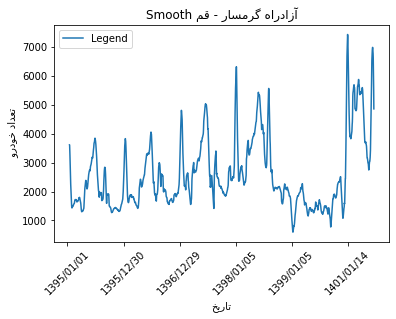

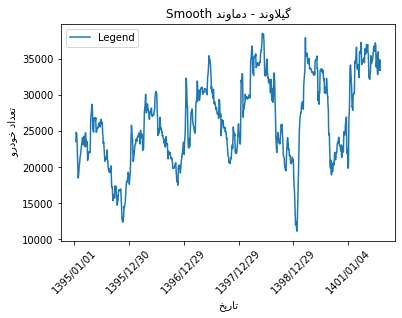

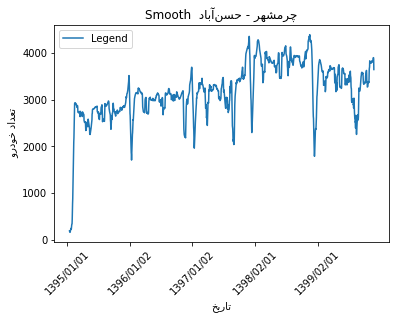

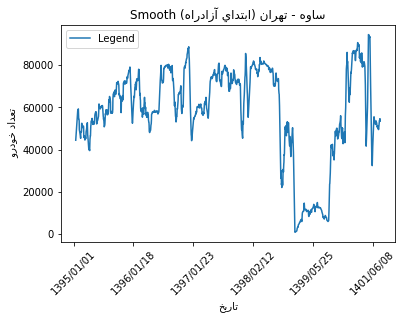

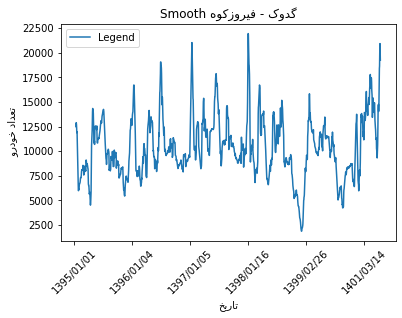

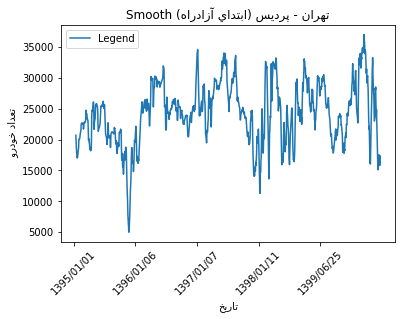

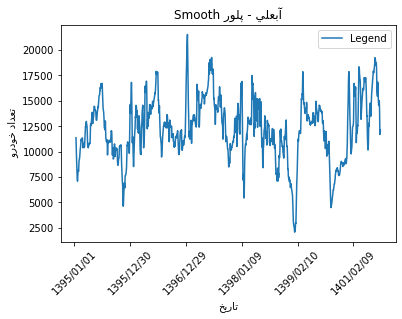

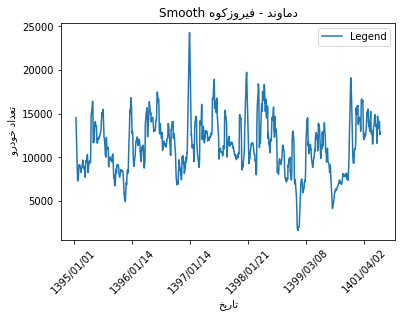

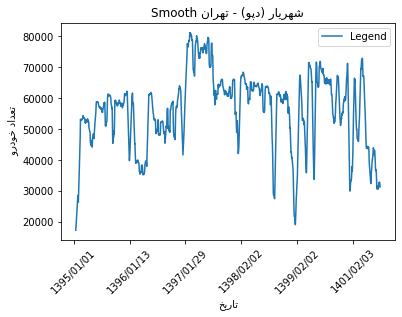

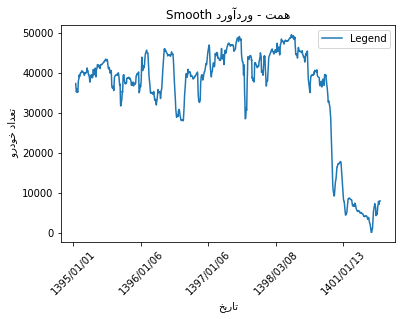

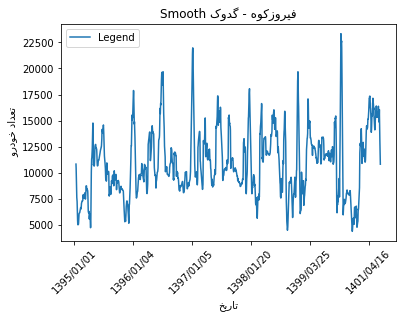

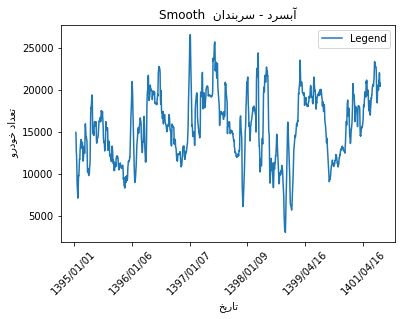

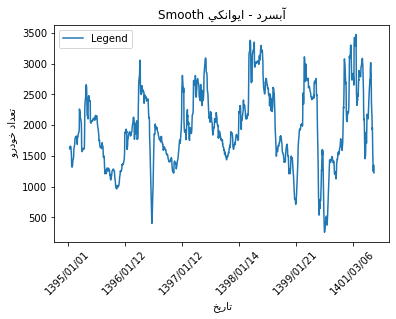

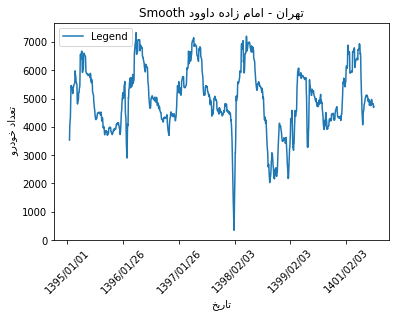

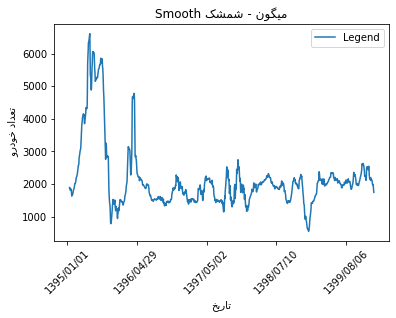

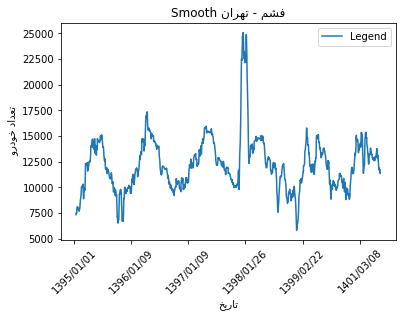

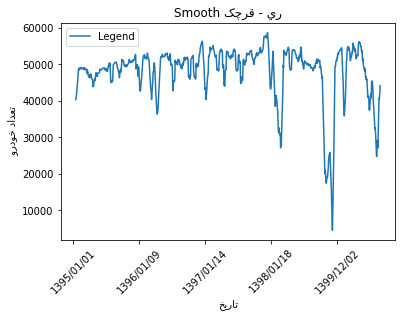

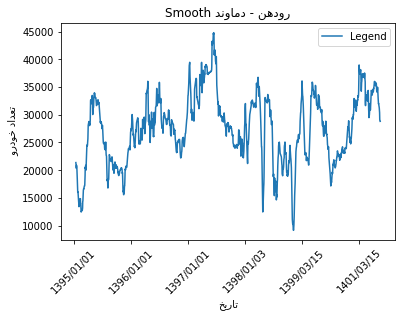

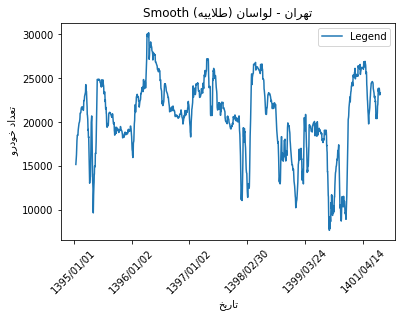

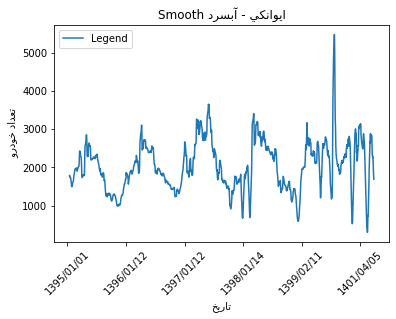

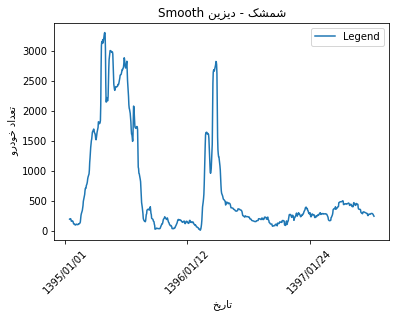

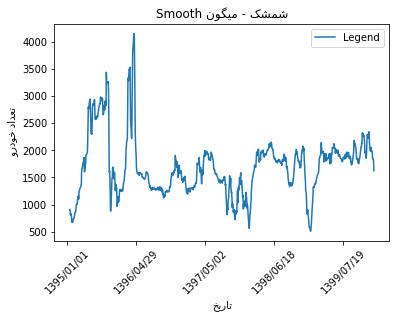

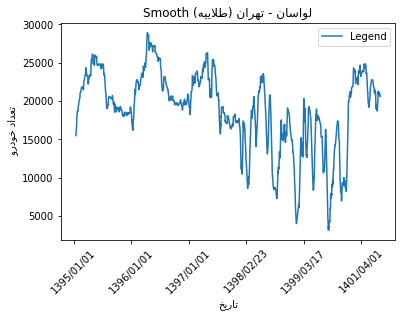

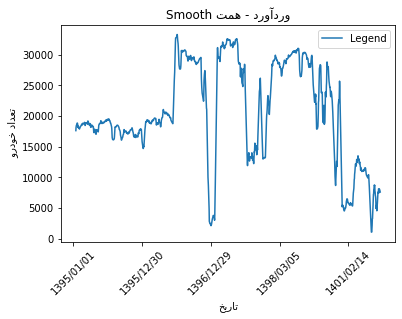

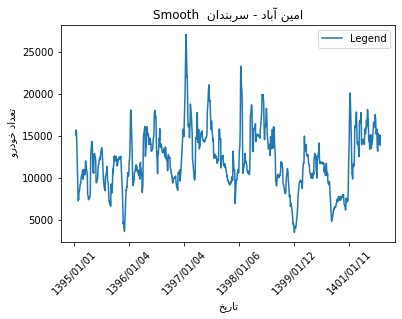

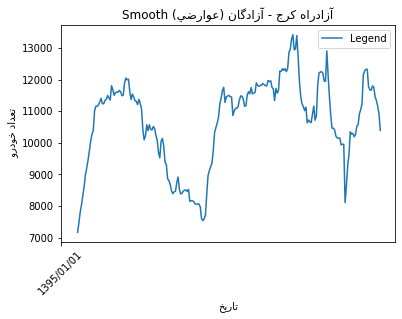

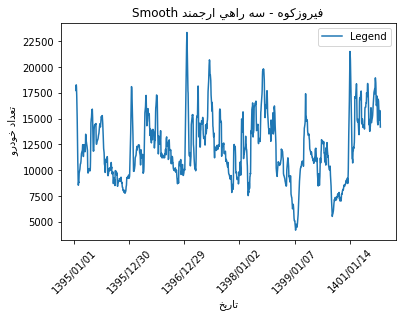

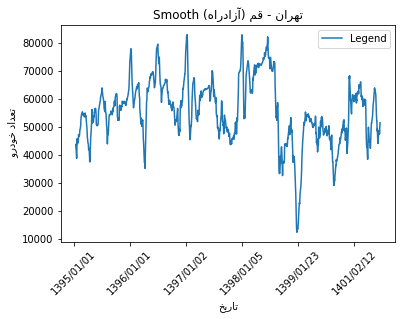

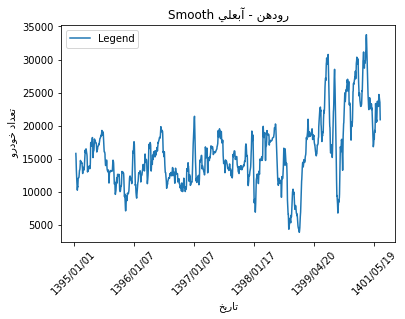

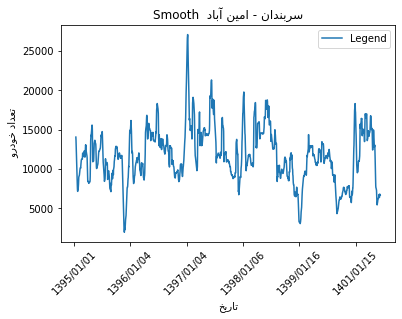

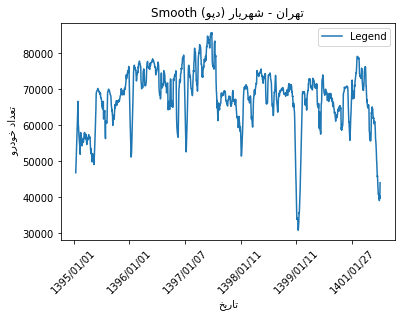

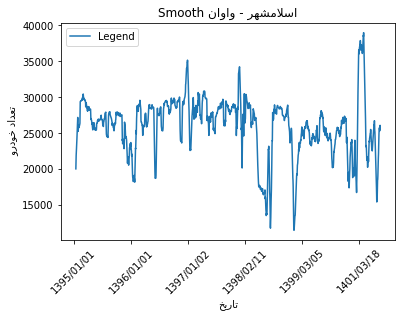

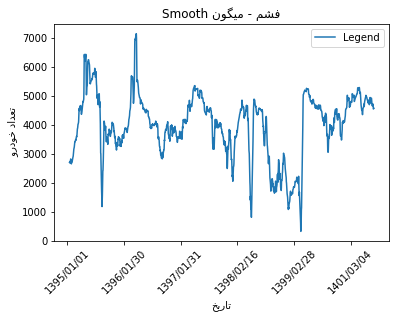

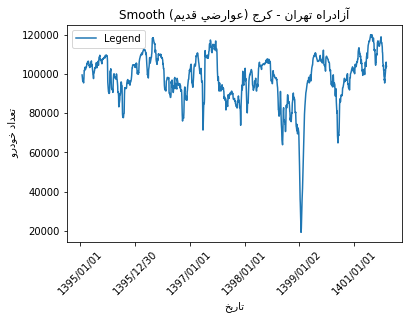

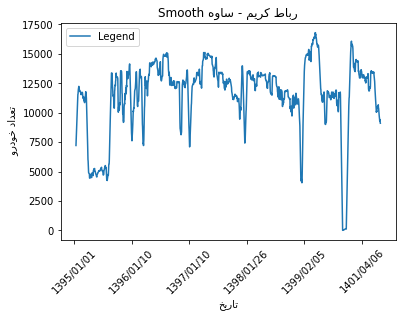

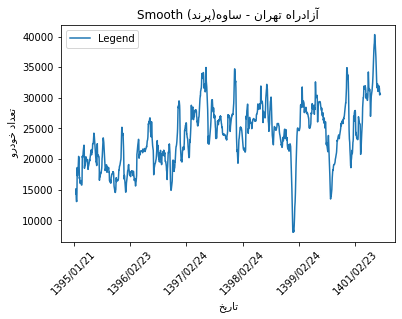

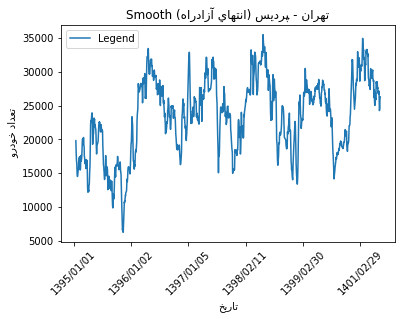

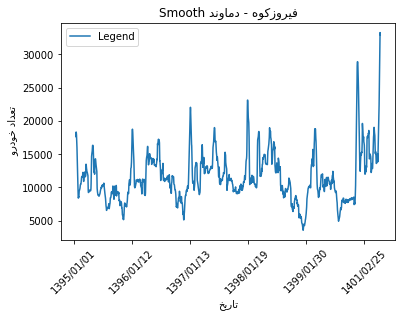

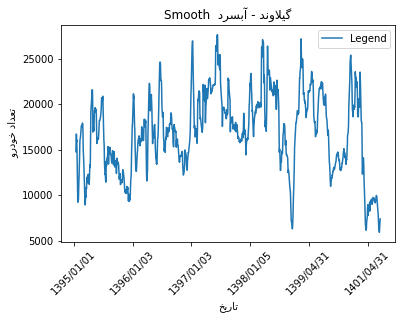

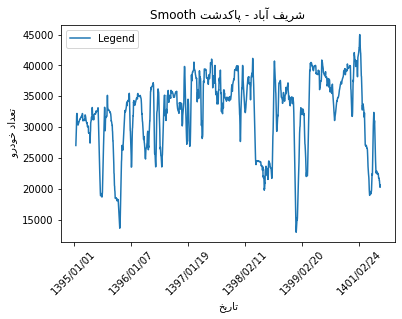

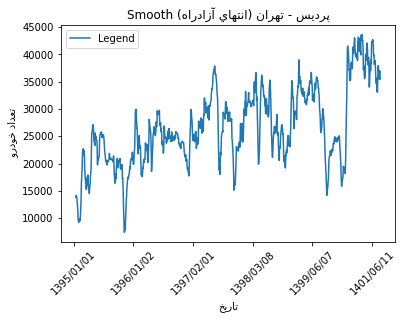

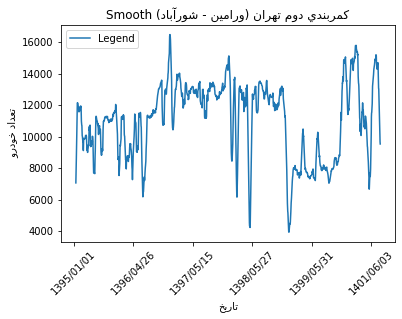

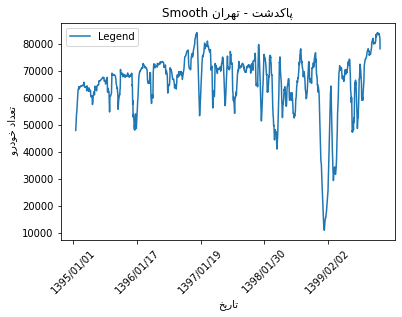

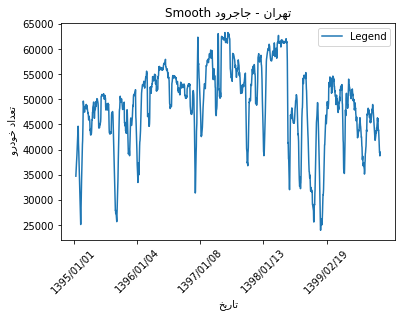

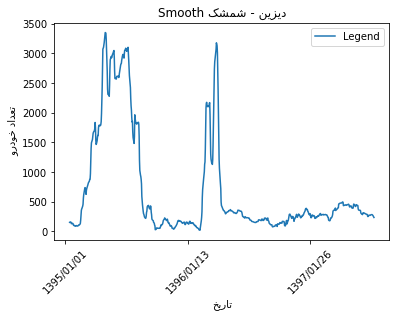

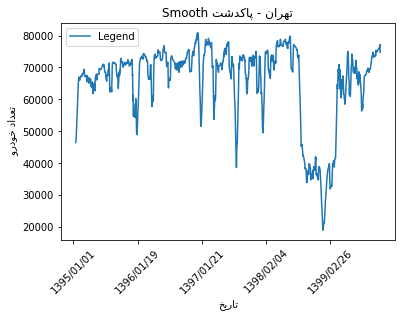

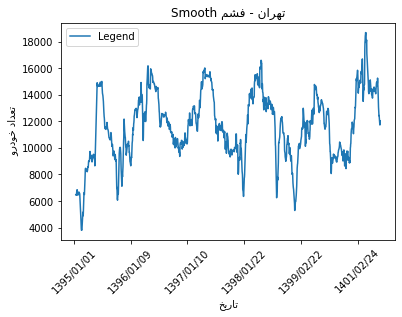

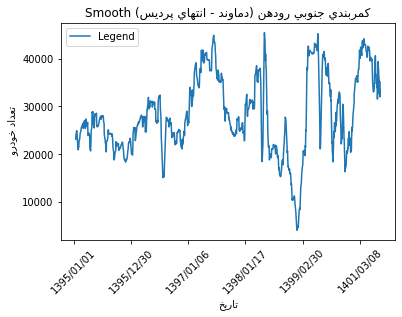

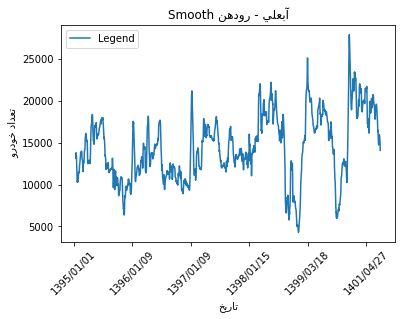

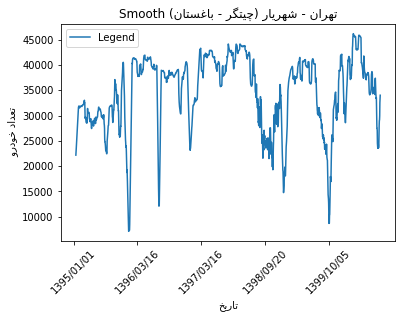

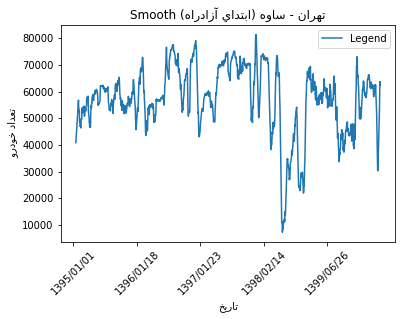

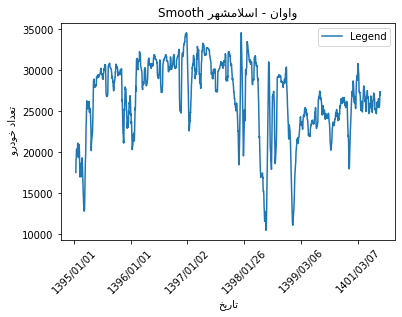

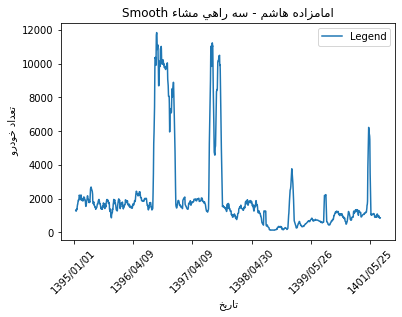

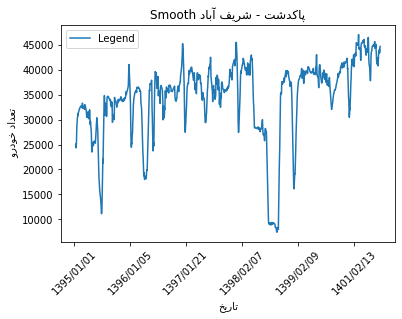

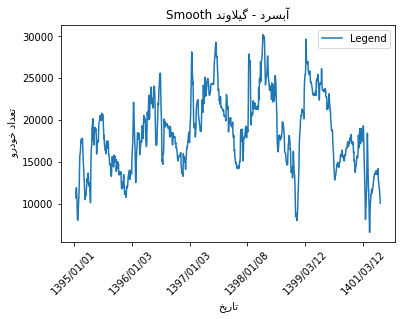

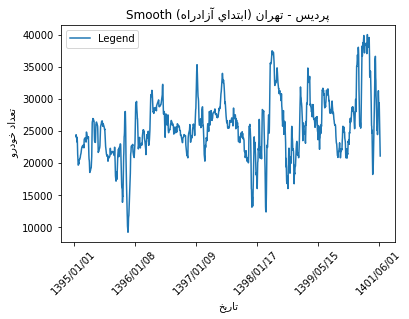

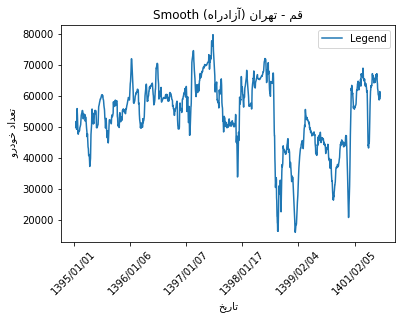

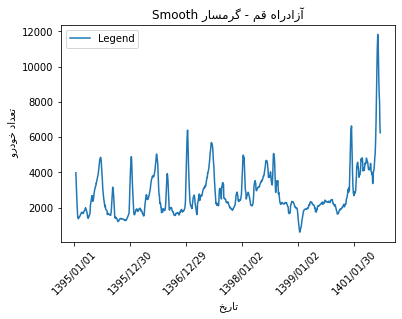

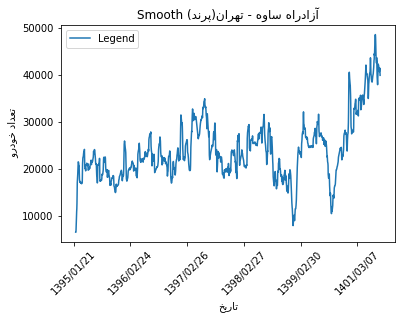

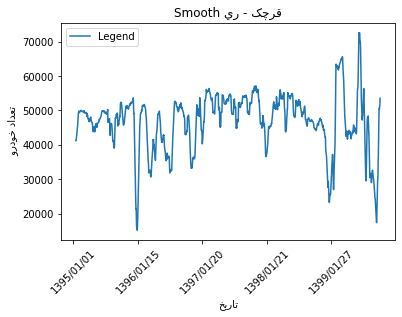

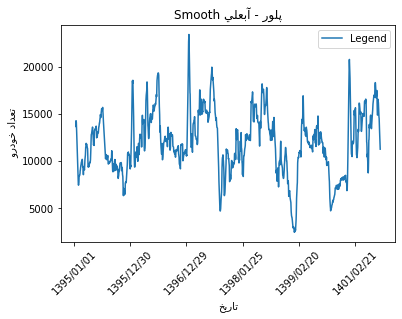

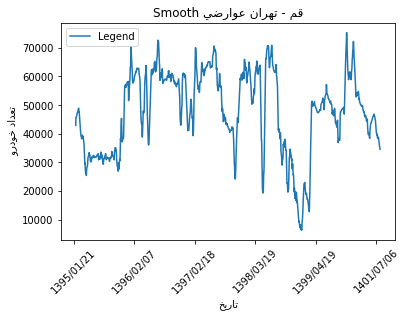

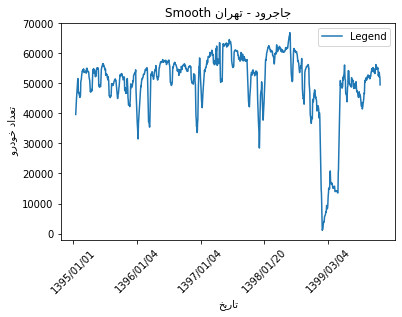

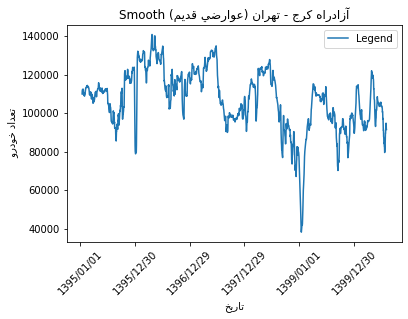

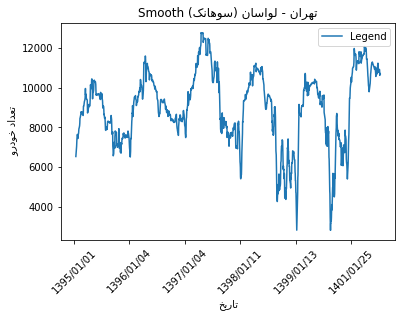

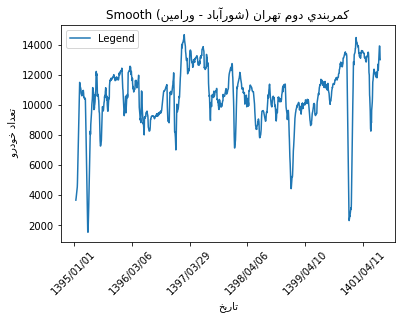

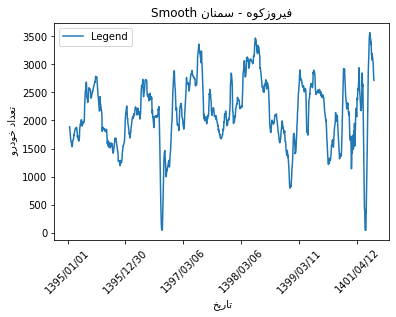

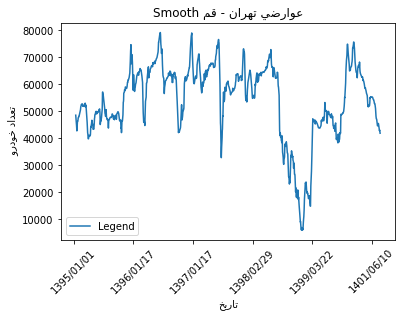

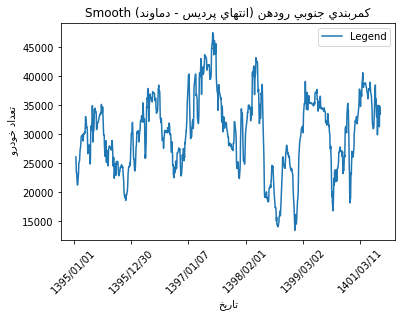

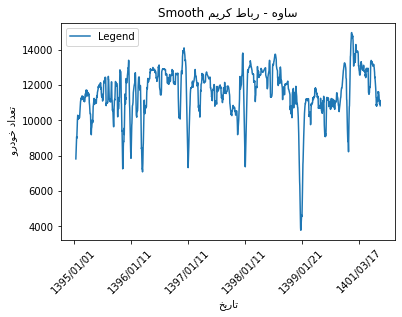

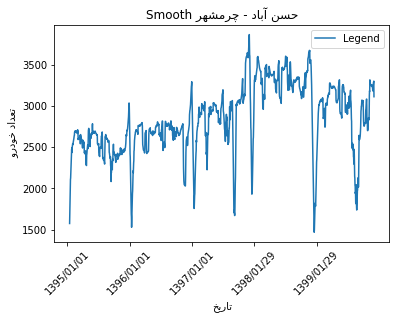

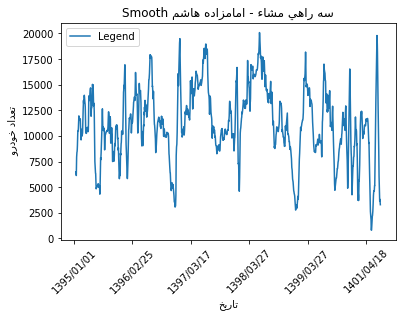

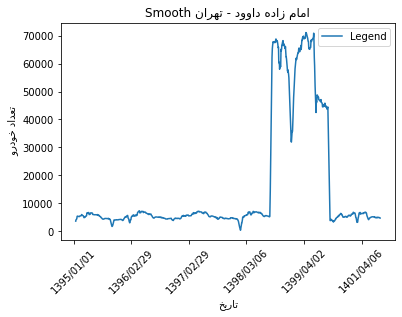

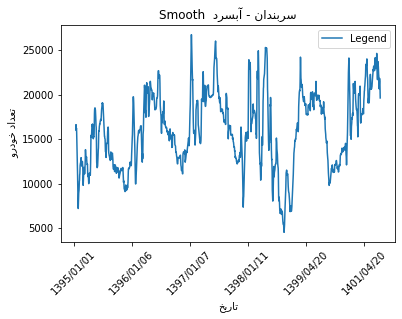

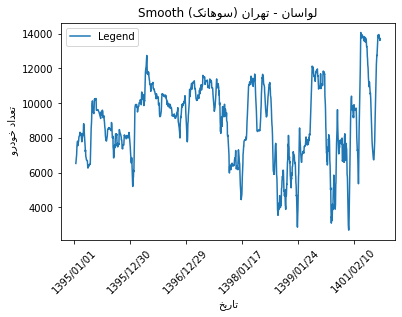

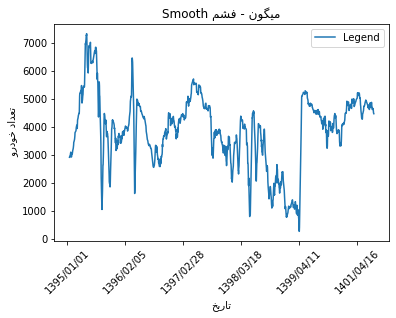

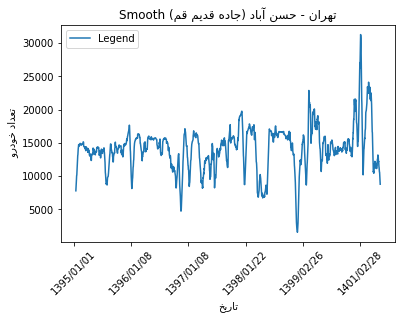

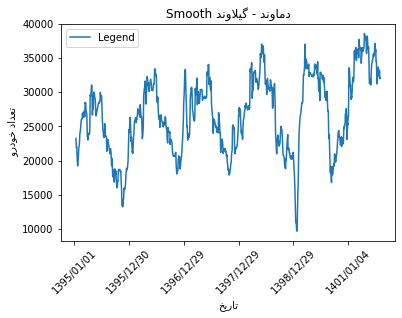

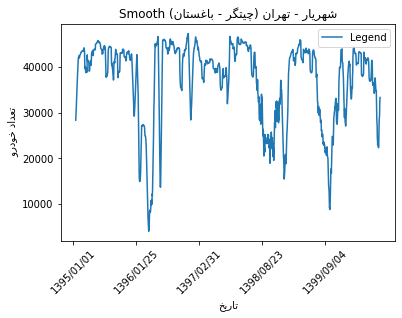

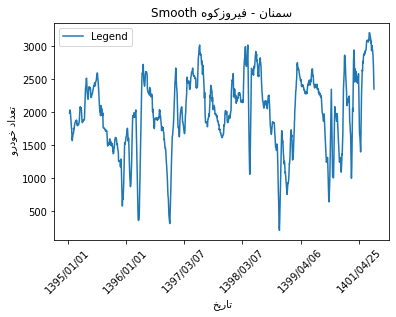

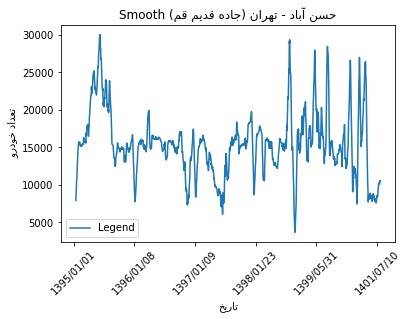

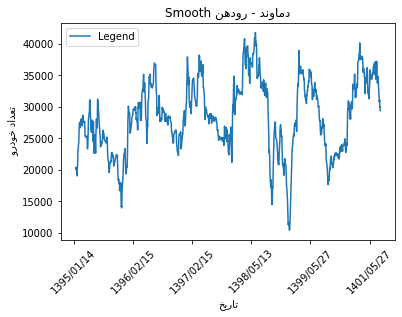

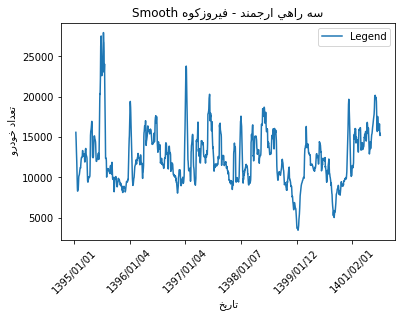

In [54]:
for code, df in roads.items():
    Draw_road_time_series_smooth(df, window=14)

# Cleaning Data:

In [55]:
# Working with an example df
df = roads['113203']

# TODO smooth worked time

# add the missing date to data
# df['تعداد کل وسیله نقلیه']
# a= df['زمان شروع']

# number of day in 7 year (1395 to 1401) 
i = 0
while i < 710:
    first_six_month = ['01','02','03','04','05','06']
    date = df['زمان شروع'][i].split('/')
    if date[1] in first_six_month:
        for day in range(1, 32):
            if int(date[2]) != day:
                # print(day)
                # print(int(date[2]))
                print("Missing date at {}/{}/{}".format(date[0],date[1], day))
            else:
                i = i + 1
                date = df['زمان شروع'][i].split('/')
    else:
        for day in range(1,31):
            if int(date[2]) != day:
                print("Missing date at {}/{}/{}".format(date[0],date[1],day))
            else:
                i = i + 1
                date = df['زمان شروع'][i].split('/')
    
# df.loc[df['مدت زمان کارکرد(دقیقه)'] < 1440]
# df.drop(columns='index', inplace=True)

from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined:

display(HTML(df.to_html()))

Missing date at 1395/10/8
Missing date at 1396/11/9
Missing date at 1397/01/30


# find intersting road :
load and then sort the road by the linearRegression results.

In [56]:
def get_LinearReg_of_road_codes(codes):
    regression = dict()
    for i in  range(len(codes)):
        model = LinearRegression()
        df = getRoadChart(codes[i])

        y = df['تعداد کل وسیله نقلیه']
        x = np.reshape(df.index, (-1,1))
        model.fit(x, y)
        regression[codes[i]] = model
    return regression

roads_reg = get_LinearReg_of_road_codes(codes)


/tmp/ipykernel_30847/881771632.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(file_handler.load_csv_file(roads[i]))


In [57]:
# for (index,name ) in enumerate(names):
#     print(names[name] + " : " + str(roads_reg[name].coef_))



# create a regression df
regression_df = pd.DataFrame(columns = ['name', '6dc', 'coef', 'r^2'])

i = 0
em = []
reg_dict = {}
for _, code in enumerate(names):
    item = {
        'name': names[code],
        'code': code,
        'coef': roads_reg[code].coef_[0],
        'intercept': roads_reg[code].intercept_,
    }
    em.append(item)

regression_df = (pd.DataFrame(em))



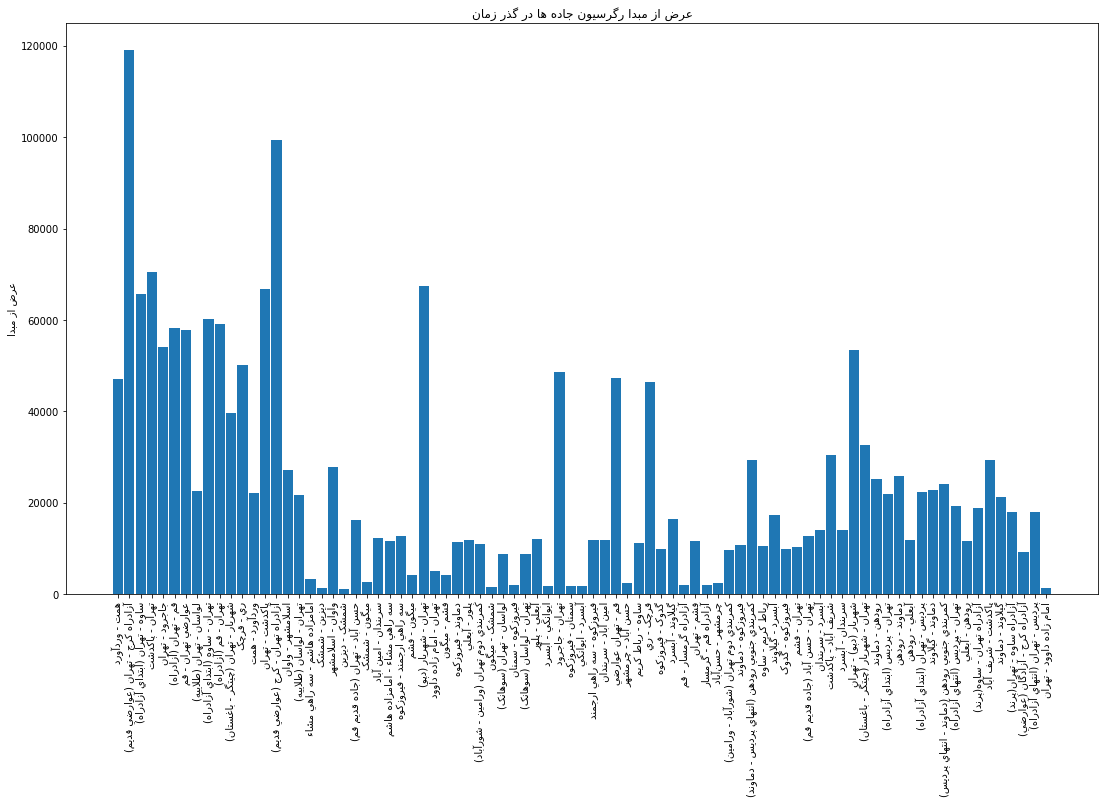

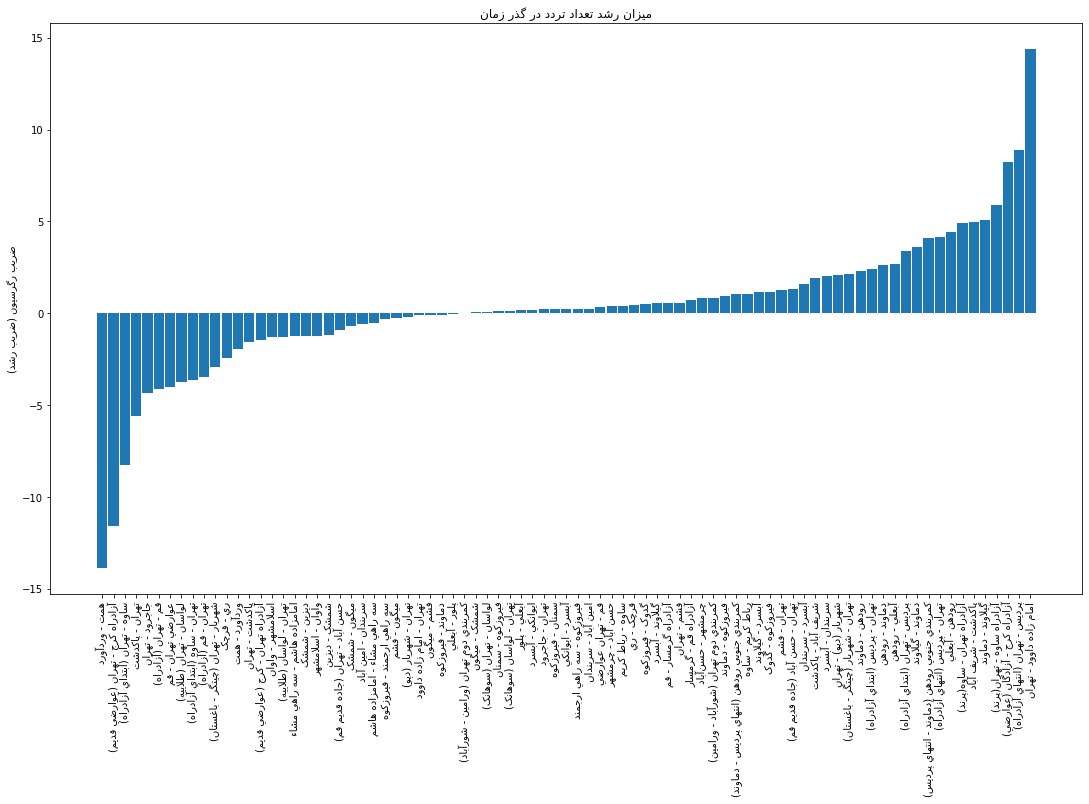

In [58]:
#Plot regression coef bar chart

fig, ax = plt.subplots()
regression_df = regression_df.sort_values(by='coef')
road_names = regression_df['name'].apply(file_handler.persian_fix)
coefs = regression_df['intercept']

ax.bar(road_names, coefs, width=0.9)
plt.xticks(rotation=90)

ax.set_ylabel(file_handler.persian_fix("عرض از مبدا"))
ax.set_title(file_handler.persian_fix("عرض از مبدا رگرسیون جاده ها در گذر زمان"))
# ax.legend(title='')
fig.set_size_inches(18.5, 10.5)
plt.savefig('img/road_growth_intercept.png', bbox_inches='tight')

plt.show()


fig, ax = plt.subplots()
regression_df = regression_df.sort_values(by='coef')
road_names = regression_df['name'].apply(file_handler.persian_fix)
coefs = regression_df['coef']

ax.bar(road_names, coefs, width=0.9)
plt.xticks(rotation=90)

ax.set_ylabel(file_handler.persian_fix("ضریب رگرسیون (ضریب رشد)"))
ax.set_title(file_handler.persian_fix("میزان رشد تعداد تردد در گذر زمان"))
# ax.legend(title='')
fig.set_size_inches(18.5, 10.5)
plt.savefig('img/road_growth_coef.png', bbox_inches='tight')

plt.show()



In [59]:
def sort_reg_form_High_to_low(regression):
    regression = {k: v for k, v in regression.items() if v != {}}
    sorted_models = sorted(regression.items(), key=lambda x: x[1].coef_[0])
    return sorted_models , regression

sorted_models , regression = sort_reg_form_High_to_low(roads_reg)
# for (name, coef) in sorted_models:
#     print(names[name], regression[name].coef_)

sorted_models[-1][1].coef_

array([14.37348474])

## check the extrime change in top roads
we sorted the road form most groth to least (negative) grouth , we only care about the extrem ones.

total road number
83


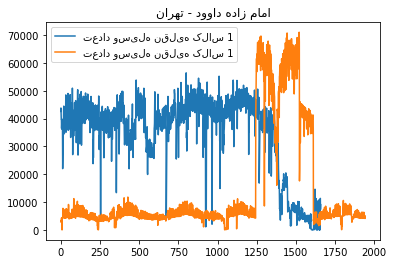

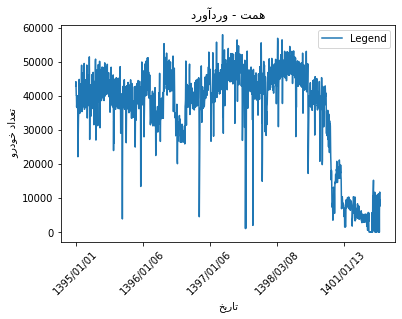

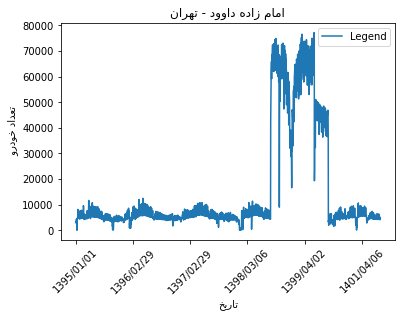

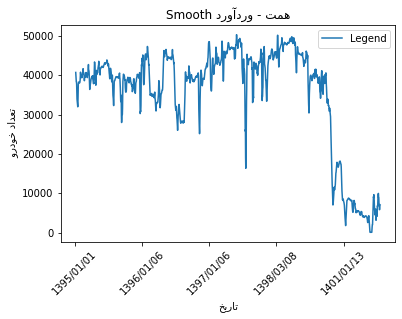

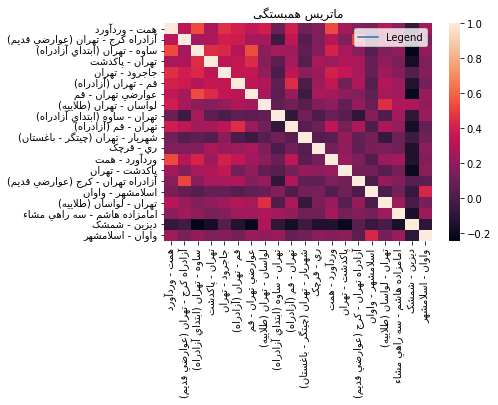

In [109]:
# Now lets plot some of these.
import file_handler
import importlib
importlib.reload(file_handler)

print("total road number")
print(len(sorted_models))

road_min = sorted_models[0]
road_max = sorted_models[-1]
df1=roads[road_min[0]]
df2=roads[road_max[0]]
ax = df1.iloc[:, [6]].plot(title=file_handler.persian_fix(names[road_min[0]]))
df2.iloc[:, [6]].plot(ax = ax, title=file_handler.persian_fix(names[road_max[0]]))


Draw_road_time_series(df1)
Draw_road_time_series(df2)
Draw_road_time_series_smooth(df1)
Draw_road_time_series_smooth(df2)
Draw_road_corr_matrix(20,sorted_models)

# show data on map :

## map of our data

In [ ]:
def load_the_map_of_city(place,custom_filter,bbox):
    G = ox.graph_from_bbox(bbox=(36.1290,35.1525,52.4501,50.2940), retain_all=True, simplify = True, network_type='all', custom_filter=cf)
    # Prepare data
    u = []
    v = []
    key = []
    data = []
    for uu, vv, kkey, ddata in G.edges(keys=True, data=True): # added ww
        u.append(uu)
        v.append(vv)
        key.append(kkey)
        data.append(ddata)
    return G,data

def find_road_in_map_by_code(data,code):
    for item in data:
        if item.get('osmid') == code:
            print(item)

In [ ]:
place = ["Tehran, Iran"]
cf = '["highway"~"trunk|motorway|primary"]'
bbox=(36.0290,35.0525,52.3501,50.1940)

G, data = load_the_map_of_city(place,cf,bbox)
find_road_in_map_by_code(data,4480201)

### code of importent road

In [ ]:
from osmid import osmid_codes, osmid_names

In [ ]:
def map_drawer(data):
    roadCols = []
    edge_width = []
    # cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","orange", "green"])
    cmap = mpl.colormaps['turbo'].resampled(80)
    for item in data:
        mark = False
        if(item['osmid'] == '667922913'):
            print('salam')
        if "osmid" in item.keys():
            # Check by code
            if type(item['osmid']) == list:
                # if a road has multiple osmid's see if any of them intersects.
                if len(set(item['osmid']).intersection(set(osmid_codes.keys()))) > 0:
                    edge = 5
                    mark = True
                    code = list(set(item['osmid']).intersection(
                        set(osmid_codes.keys())))[0]
            else:
                if item["osmid"] in list(osmid_codes.keys()):
                    edge = 5
                    code = item['osmid']
                    mark = True
        if mark:
            # get 6digit code
            _6d = str(osmid_codes[code])
            val = (regression[_6d].coef_)
            min = -12
            max = +12

            # normalize color
            val = (val - min)/(max - min)

            # check by names
        if ('name' in item.keys()):
            if type(item['name']) == str:
                if item["name"] in osmid_names.keys():
                    color = "#FFFFF0"
                    edge = 5
                    # els

                    mark = True
                    _6d = str(osmid_names[item['name']])
                    val = (regression[_6d].coef_)
                    min = -12
                    max = +12

                    # normalize color
                    val = (val - min)/(max - min)
        if mark:
            color = (mpl.colors.rgb2hex(cmap(val), keep_alpha=True))

        if not mark:
            color = "#00FFFF"
            edge = 0.4

        roadCols.append(color)
        edge_width.append(edge)

    # Plot
    bgcolor = "#1e1e1e"
    fig, ax = ox.plot_graph(G, node_size=0,
                            dpi=500, bgcolor=bgcolor,
                            save=False, edge_color=roadCols,
                            edge_linewidth=edge_width, edge_alpha=1, figsize=(12, 12))

    # fig, ax = ox.plot_graph(G, bgcolor='black', edge_linewidth=3, node_size=0,
    #                         show=False, close=False)
    global labels
    labels = []
    for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():
        osmid_arr = np.array(edge['osmid']).tolist()
        good = False
        name = ''

        if type(osmid_arr) == int:
            if osmid_arr in osmid_codes:
                name = edge['name']
                good = True
        elif type(osmid_arr) == list:
            for c in osmid_arr:
                if c in osmid_codes:
                    good = True
                    break
            if good:
                name = sorted(edge['name'])[0]

        if good:
            c = edge['geometry'].centroid

            ax.title.set_size(14)
            if name in labels:
                continue

            labels.append(name)
            e1 = edge

            ax.annotate(file_handler.persian_fix(name),
                        (c.x, c.y), c='blue', size=4)


    # fig.show()

    fig.tight_layout(pad=0)
    fig.savefig("heatmap.jpg", dpi=600, bbox_inches='tight', format="png",
                facecolor=fig.get_facecolor(), transparent=False)
    fig
map_drawer(data)